Epoch 0, Loss: 1.0534972244832488e+21
Epoch 10, Loss: 9.594439794964992e+20
Epoch 20, Loss: 8.730995600656685e+20
Epoch 30, Loss: 7.914773759503683e+20
Epoch 40, Loss: 7.131241014770973e+20
Epoch 50, Loss: 6.374671461744818e+20
Epoch 60, Loss: 5.6381928888688286e+20
Epoch 70, Loss: 4.912820263042679e+20
Epoch 80, Loss: 4.197736251302745e+20
Epoch 90, Loss: 3.49619751912957e+20
Epoch 100, Loss: 2.814289907363359e+20
Epoch 110, Loss: 2.1674869750831985e+20
Epoch 120, Loss: 1.582274110222678e+20
Epoch 130, Loss: 1.0910091483388733e+20
Epoch 140, Loss: 7.171787573127073e+19
Epoch 150, Loss: 4.645276978265247e+19
Epoch 160, Loss: 3.1205076780189745e+19
Epoch 170, Loss: 2.2468533307742093e+19
Epoch 180, Loss: 1.7139766696400126e+19
Epoch 190, Loss: 1.346523072220994e+19
Epoch 200, Loss: 1.0734888263744487e+19
Epoch 210, Loss: 8.660751387165983e+18
Epoch 220, Loss: 7.068833922250965e+18
Epoch 230, Loss: 5.834816838025871e+18
Epoch 240, Loss: 4.872835423186977e+18
Epoch 250, Loss: 4.1214052623

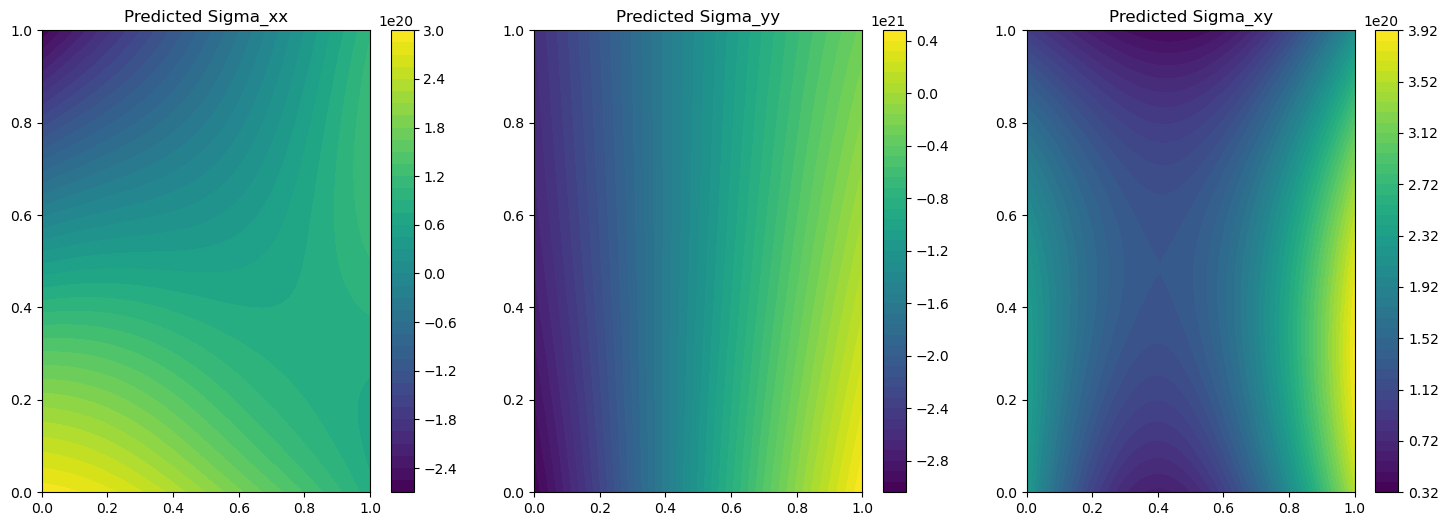

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import equinox as eqx
import matplotlib.pyplot as plt

# Physical constants
E = 210e9  # Young's modulus (Pa)
nu = 0.3   # Poisson's ratio
L = 1.0    # Length of the plate (m)
P = 1e6    # Applied load (N)

# Characteristic scales for non-dimensionalization
sigma_char = E  # Characteristic stress
x_char = L      # Characteristic length
u_char = P * L / E  # Characteristic displacement

# Non-dimensionalize function
def nondimensionalize(x, y):
    return x / x_char, y / x_char

def dimensionalize_displacement(u_nd, v_nd):
    return u_nd * u_char, v_nd * u_char

def dimensionalize_stress(sigma_xx_nd, sigma_yy_nd, sigma_xy_nd):
    return sigma_xx_nd * sigma_char, sigma_yy_nd * sigma_char, sigma_xy_nd * sigma_char

# Define the PINN model with residual blocks
class ResidualBlock(eqx.Module):
    linear1: eqx.nn.Linear
    linear2: eqx.nn.Linear

    def __init__(self, dim, key):
        keys = jax.random.split(key, 2)
        self.linear1 = eqx.nn.Linear(dim, dim, key=keys[0])
        self.linear2 = eqx.nn.Linear(dim, dim, key=keys[1])

    def __call__(self, x):
        y = jax.nn.tanh(self.linear1(x))
        return x + self.linear2(y)

class PINN(eqx.Module):
    input_layer: eqx.nn.Linear
    hidden_layers: list
    output_layer: eqx.nn.Linear

    def __init__(self, key):
        keys = jax.random.split(key, 7)
        self.input_layer = eqx.nn.Linear(2, 64, key=keys[0])
        self.hidden_layers = [
            ResidualBlock(64, keys[i]) for i in range(1, 6)
        ]
        self.output_layer = eqx.nn.Linear(64, 2, key=keys[6])

    def __call__(self, x):
        x = jax.nn.tanh(self.input_layer(x))
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Calculate strain from the model's predictions
def calculate_strain(model, x_nd, y_nd):
    xy = jnp.array([x_nd, y_nd])
    u_v = model(xy)
    u = u_v[0]
    v = u_v[1]
    
    grad_u = jax.jacfwd(lambda x: model(x)[0])(xy)
    grad_v = jax.jacfwd(lambda x: model(x)[1])(xy)
    
    epsilon_xx = grad_u[0]
    epsilon_yy = grad_v[1]
    epsilon_xy = 0.5 * (grad_u[1] + grad_v[0])
    return epsilon_xx, epsilon_yy, epsilon_xy

# Calculate stress from strain
def calculate_stress(epsilon_xx, epsilon_yy, epsilon_xy):
    sigma_xx = E / (1 - nu**2) * (epsilon_xx + nu * epsilon_yy)
    sigma_yy = E / (1 - nu**2) * (epsilon_yy + nu * epsilon_xx)
    sigma_xy = E / (2 * (1 + nu)) * epsilon_xy
    return sigma_xx, sigma_yy, sigma_xy

# Calculate the PDE residual
@eqx.filter_jit
def pde_residual(model, x_nd, y_nd):
    epsilon_xx, epsilon_yy, epsilon_xy = calculate_strain(model, x_nd, y_nd)
    sigma_xx, sigma_yy, sigma_xy = calculate_stress(epsilon_xx, epsilon_yy, epsilon_xy)
    
    d_sigma_xx_dx = jax.grad(lambda x: calculate_stress(*calculate_strain(model, x, y_nd))[0])(x_nd)
    d_sigma_xy_dy = jax.grad(lambda y: calculate_stress(*calculate_strain(model, x_nd, y))[2])(y_nd)
    d_sigma_xy_dx = jax.grad(lambda x: calculate_stress(*calculate_strain(model, x, y_nd))[2])(x_nd)
    d_sigma_yy_dy = jax.grad(lambda y: calculate_stress(*calculate_strain(model, x_nd, y))[1])(y_nd)
    
    res_x = d_sigma_xx_dx + d_sigma_xy_dy
    res_y = d_sigma_xy_dx + d_sigma_yy_dy
    
    return res_x, res_y

# Define the loss function
@eqx.filter_jit
def loss_fn(model, x, y):
    x_nd, y_nd = nondimensionalize(x, y)
    res_x, res_y = jax.vmap(pde_residual, in_axes=(None, 0, 0))(model, x_nd, y_nd)
    pde_loss = jnp.mean(res_x**2 + res_y**2)
    
    u_v_left = jax.vmap(lambda y: model(jnp.array([0.0, y])))(y_nd)
    u_v_right = jax.vmap(lambda y: model(jnp.array([1.0, y])))(y_nd)
    u_v_bottom = jax.vmap(lambda x: model(jnp.array([x, 0.0])))(x_nd)
    u_v_top = jax.vmap(lambda x: model(jnp.array([x, 1.0])))(x_nd)
    
    P_nd = P / sigma_char
    bc_loss = (
        jnp.mean(u_v_left[:, 0]**2) +
        jnp.mean((u_v_right[:, 0] - P_nd)**2) +
        jnp.mean(u_v_bottom[:, 1]**2) +
        jnp.mean(u_v_top[:, 1]**2)
    )
    
    return pde_loss + bc_loss

# Calculate loss and gradients
@eqx.filter_value_and_grad
def loss_and_grad(model, x, y):
    return loss_fn(model, x, y)

# Define a single training step
@eqx.filter_jit
def train_step(model, opt_state, x, y):
    loss, grads = loss_and_grad(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

# Prediction functions
def predict_stress(model, x, y):
    x_nd, y_nd = nondimensionalize(x, y)
    epsilon_xx, epsilon_yy, epsilon_xy = calculate_strain(model, x_nd, y_nd)
    sigma_xx_nd, sigma_yy_nd, sigma_xy_nd = calculate_stress(epsilon_xx, epsilon_yy, epsilon_xy)
    return dimensionalize_stress(sigma_xx_nd, sigma_yy_nd, sigma_xy_nd)

def predict_displacement(model, x, y):
    x_nd, y_nd = nondimensionalize(x, y)
    u_nd, v_nd = model(jnp.array([x_nd, y_nd]))
    return dimensionalize_displacement(u_nd, v_nd)

# Function to calculate relative error
def relative_error(predicted, exact):
    return jnp.abs((predicted - exact) / exact)

# Exact solutions (to be implemented based on your specific problem)
def exact_stress(x, y):
    # Implement exact stress calculation here
    # This is a placeholder implementation
    sigma_xx = P * y / L
    sigma_yy = 0
    sigma_xy = 0
    return sigma_xx, sigma_yy, sigma_xy

def exact_displacement(x, y):
    # Implement exact displacement calculation here
    # This is a placeholder implementation
    u = P * x * y / (E * L)
    v = -nu * P * x * y / (E * L)
    return u, v

# Initialize model and optimizer
key = jax.random.PRNGKey(0)
model = PINN(key)
optimizer = optax.adam(1e-4)
scheduler = optax.piecewise_constant_schedule(init_value=1e-4, boundaries_and_scales={1000: 0.1, 2000: 0.01})
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

# Training loop
x_train = jnp.linspace(0, L, 50)
y_train = jnp.linspace(0, L, 50)
x_mesh, y_mesh = jnp.meshgrid(x_train, y_train)
x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()

num_epochs = 2000
for epoch in range(num_epochs):
    model, opt_state, loss = train_step(model, opt_state, x_flat, y_flat)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Testing the trained model
x_test = 0.92
y_test = 0.5
sigma_xx_pred, sigma_yy_pred, sigma_xy_pred = predict_stress(model, x_test, y_test)
u_pred, v_pred = predict_displacement(model, x_test, y_test)

print(f"Predicted stress at ({x_test}, {y_test}): sigma_xx = {sigma_xx_pred}, sigma_yy = {sigma_yy_pred}, sigma_xy = {sigma_xy_pred}")
print(f"Predicted displacement at ({x_test}, {y_test}): u = {u_pred}, v = {v_pred}")

# Exact values for comparison
sigma_xx_exact, sigma_yy_exact, sigma_xy_exact = exact_stress(x_test, y_test)
u_exact, v_exact = exact_displacement(x_test, y_test)

print(f"Exact stress at ({x_test}, {y_test}): sigma_xx = {sigma_xx_exact}, sigma_yy = {sigma_yy_exact}, sigma_xy = {sigma_xy_exact}")
print(f"Exact displacement at ({x_test}, {y_test}): u = {u_exact}, v = {v_exact}")

# Calculate and print the relative errors
rel_error_sigma_xx = relative_error(sigma_xx_pred, sigma_xx_exact)
rel_error_sigma_yy = relative_error(sigma_yy_pred, sigma_yy_exact)
rel_error_sigma_xy = relative_error(sigma_xy_pred, sigma_xy_exact)
rel_error_u = relative_error(u_pred, u_exact)
rel_error_v = relative_error(v_pred, v_exact)

print(f"Relative error in sigma_xx: {rel_error_sigma_xx}")
print(f"Relative error in sigma_yy: {rel_error_sigma_yy}")
print(f"Relative error in sigma_xy: {rel_error_sigma_xy}")
print(f"Relative error in u: {rel_error_u}")
print(f"Relative error in v: {rel_error_v}")

# Visualization of results
def visualize_results(model):
    x_test = jnp.linspace(0, L, 50)
    y_test = jnp.linspace(0, L, 50)
    x_mesh, y_mesh = jnp.meshgrid(x_test, y_test)

    sigma_xx_pred, sigma_yy_pred, sigma_xy_pred = jax.vmap(predict_stress, in_axes=(None, 0, 0))(model, x_mesh.flatten(), y_mesh.flatten())
    sigma_xx_pred = sigma_xx_pred.reshape(x_mesh.shape)
    sigma_yy_pred = sigma_yy_pred.reshape(x_mesh.shape)
    sigma_xy_pred = sigma_xy_pred.reshape(x_mesh.shape)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    c1 = axes[0].contourf(x_mesh, y_mesh, sigma_xx_pred, levels=50, cmap='viridis')
    fig.colorbar(c1, ax=axes[0])
    axes[0].set_title('Predicted Sigma_xx')
    
    c2 = axes[1].contourf(x_mesh, y_mesh, sigma_yy_pred, levels=50, cmap='viridis')
    fig.colorbar(c2, ax=axes[1])
    axes[1].set_title('Predicted Sigma_yy')

    c3 = axes[2].contourf(x_mesh, y_mesh, sigma_xy_pred, levels=50, cmap='viridis')
    fig.colorbar(c3, ax=axes[2])
    axes[2].set_title('Predicted Sigma_xy')

    plt.show()

visualize_results(model)
